<a href="https://colab.research.google.com/github/AllenHuang03/104947567_concept2/blob/Prediction-Models/B_predict_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# UNSW_NB15 LSTM Prediction Model

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib
import zipfile
from google.colab import files


# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
file_path = '/content/drive/My Drive/UNSW_NB15_training-set.csv'  # Change to your file path
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Preprocess data
df['cumulative_dur'] = df['dur'].cumsum()
df['timestamp'] = pd.to_datetime('2024-10-12') + pd.to_timedelta(df['cumulative_dur'], unit='s')
df.set_index('timestamp', inplace=True)

# Clean the 'sbyte' column
df['sbytes'] = pd.to_numeric(df['sbytes'], errors='coerce')
df = df.dropna(subset=['sbytes'])

# Resample to hourly data and handle any remaining NaNs
df_hourly = df['sbytes'].resample('1H').mean().interpolate()

# Check for any remaining NaNs
if df_hourly.isnull().sum() > 0:
    print(f"Warning: {df_hourly.isnull().sum()} NaN values remain after interpolation.")
    df_hourly = df_hourly.dropna()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_hourly.values.reshape(-1, 1))

<ipython-input-44-71616f82b17d>:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['sbytes'].resample('1H').mean().interpolate()


In [45]:
# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

seq_length = 24  # Use 24 hours of data to predict the next hour
X, y = create_sequences(scaled_data, seq_length)


In [46]:
# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [47]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.1510 - val_loss: 0.0389
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1434 - val_loss: 0.0367
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1367 - val_loss: 0.0345
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1302 - val_loss: 0.0324
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1233 - val_loss: 0.0304
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1160 - val_loss: 0.0285
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1086 - val_loss: 0.0268
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.1009 - val_loss: 0.0254
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0928 - val_loss: 0.0245
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0844 - val_loss: 0.0242
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0760 - val_loss: 0.0249
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0677 - val_loss: 0.0270
Epo

In [49]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


In [50]:

# Invert predictions to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


In [51]:
# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 9339.117959396988
Test RMSE: 9236.812103540118


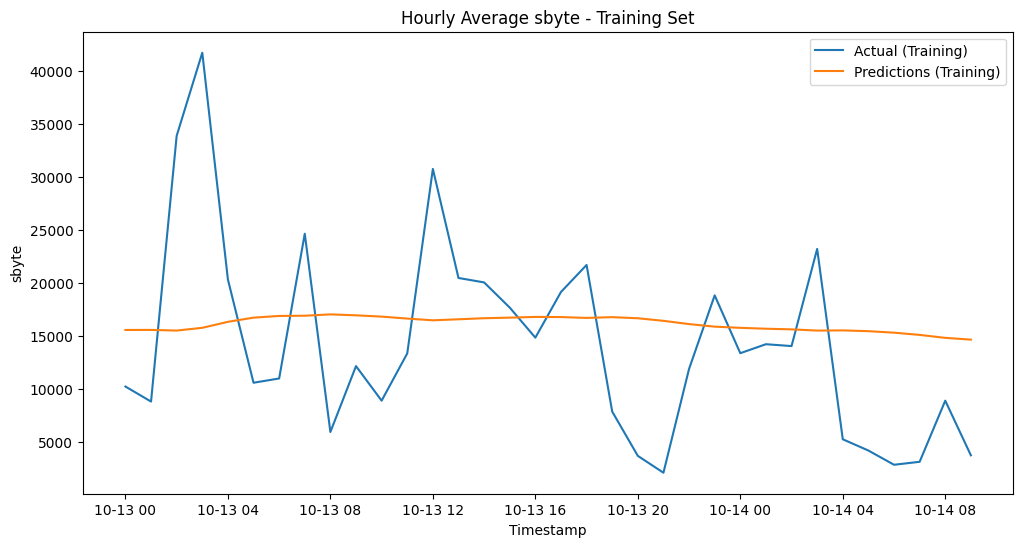

In [52]:
# Plot results for training set
plt.figure(figsize=(12, 6))
plt.plot(df_hourly.index[seq_length:train_size+seq_length], y_train_inv, label='Actual (Training)')
plt.plot(df_hourly.index[seq_length:train_size+seq_length], train_predict, label='Predictions (Training)')
plt.xlabel('Timestamp')
plt.ylabel('sbyte')
plt.title('Hourly Average sbyte - Training Set')
plt.legend()
plt.show()


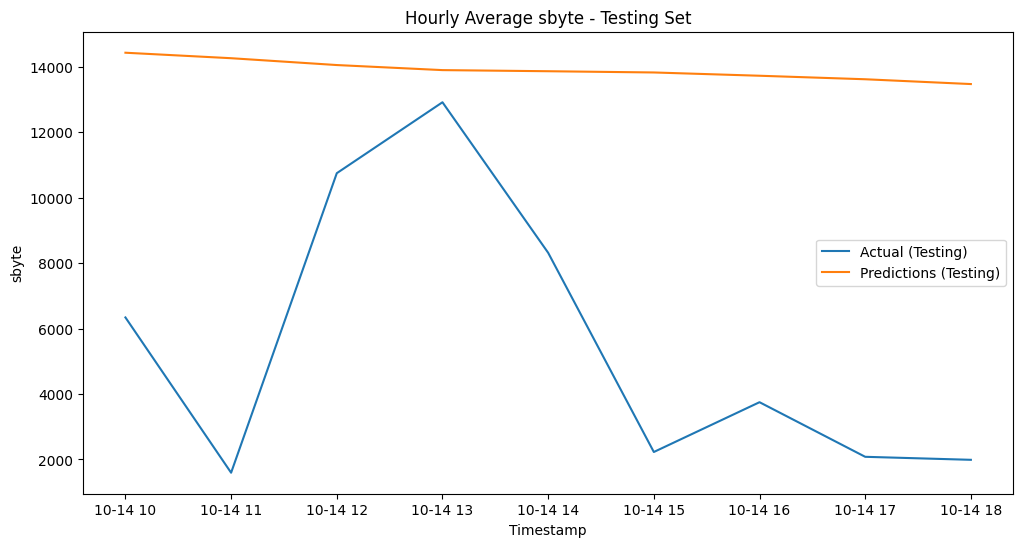

In [53]:
# Plot results for testing set
plt.figure(figsize=(12, 6))
plt.plot(df_hourly.index[train_size+seq_length:], y_test_inv, label='Actual (Testing)')
plt.plot(df_hourly.index[train_size+seq_length:], test_predict, label='Predictions (Testing)')
plt.xlabel('Timestamp')
plt.ylabel('sbyte')
plt.title('Hourly Average sbyte - Testing Set')
plt.legend()
plt.show()



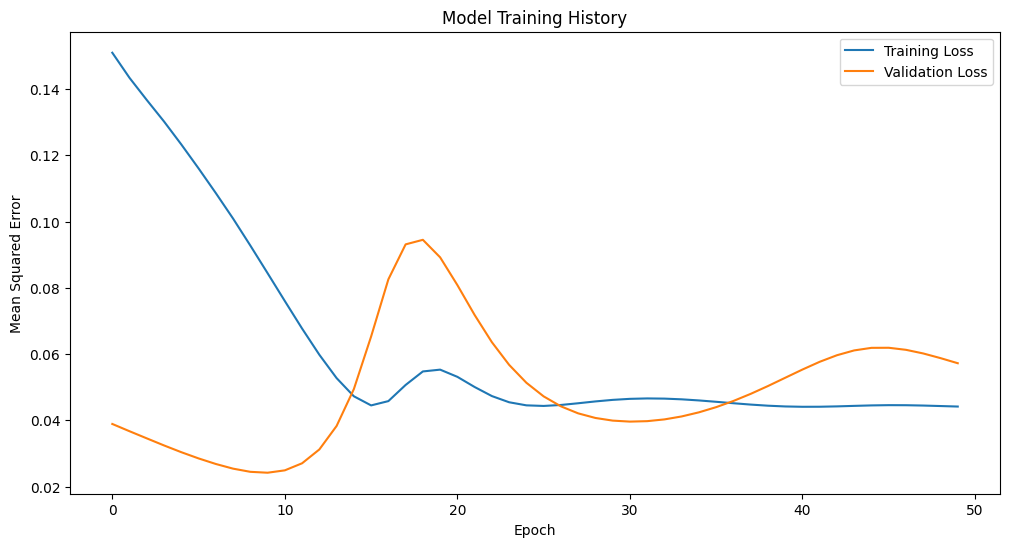

In [54]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Model Training History')
plt.legend()
plt.show()

In [55]:
# Save the trained model
model.save('lstm_model.h5')
print("Model saved as 'lstm_model.h5'")

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

# Save the hourly data
df_hourly.to_csv('hourly_data.csv')
print("Hourly data saved as 'hourly_data.csv'")

# Save any other relevant objects
joblib.dump(seq_length, 'seq_length.joblib')
print("Sequence length saved as 'seq_length.joblib'")

print("\nModels have been trained and saved successfully.")

# Zip the saved models and files
model_files = ['lstm_model.h5', 'scaler.pkl', 'hourly_data.csv', 'seq_length.joblib']

with zipfile.ZipFile('pred_models.zip', 'w') as zipf:
    for file in model_files:
        zipf.write(file)

print("Models and related files have been zipped successfully.")

# If you're using Google Colab, use this to download the zip file
files.download('pred_models.zip')

# Optional: List contents of the zip file (for verification)
with zipfile.ZipFile('pred_models.zip', 'r') as zipf:
    print("Contents of the zip file:")
    print(zipf.namelist())

Model saved as 'lstm_model.h5'
Scaler saved as 'scaler.pkl'
Hourly data saved as 'hourly_data.csv'
Sequence length saved as 'seq_length.joblib'

Models have been trained and saved successfully.
Models and related files have been zipped successfully.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Contents of the zip file:
['lstm_model.h5', 'scaler.pkl', 'hourly_data.csv', 'seq_length.joblib']


In [56]:
# Function to make predictions
def make_prediction(last_24_hours):
    last_24_hours_scaled = scaler.transform(last_24_hours.reshape(-1, 1))
    X_next = last_24_hours_scaled.reshape(1, 24, 1)
    next_hour_scaled = model.predict(X_next)
    return scaler.inverse_transform(next_hour_scaled)[0][0]

# Get the last 7 days of data
last_7_days = df_hourly[-168:]

# Make predictions for the next 24 hours
predictions = []
last_24_hours = last_7_days[-24:].values

for _ in range(24):
    next_hour = make_prediction(last_24_hours)
    predictions.append(next_hour)
    last_24_hours = np.append(last_24_hours[1:], next_hour)

# Create a date range for the predictions
prediction_dates = pd.date_range(start=last_7_days.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<ipython-input-56-6ca1935afdc7>:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  prediction_dates = pd.date_range(start=last_7_days.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')


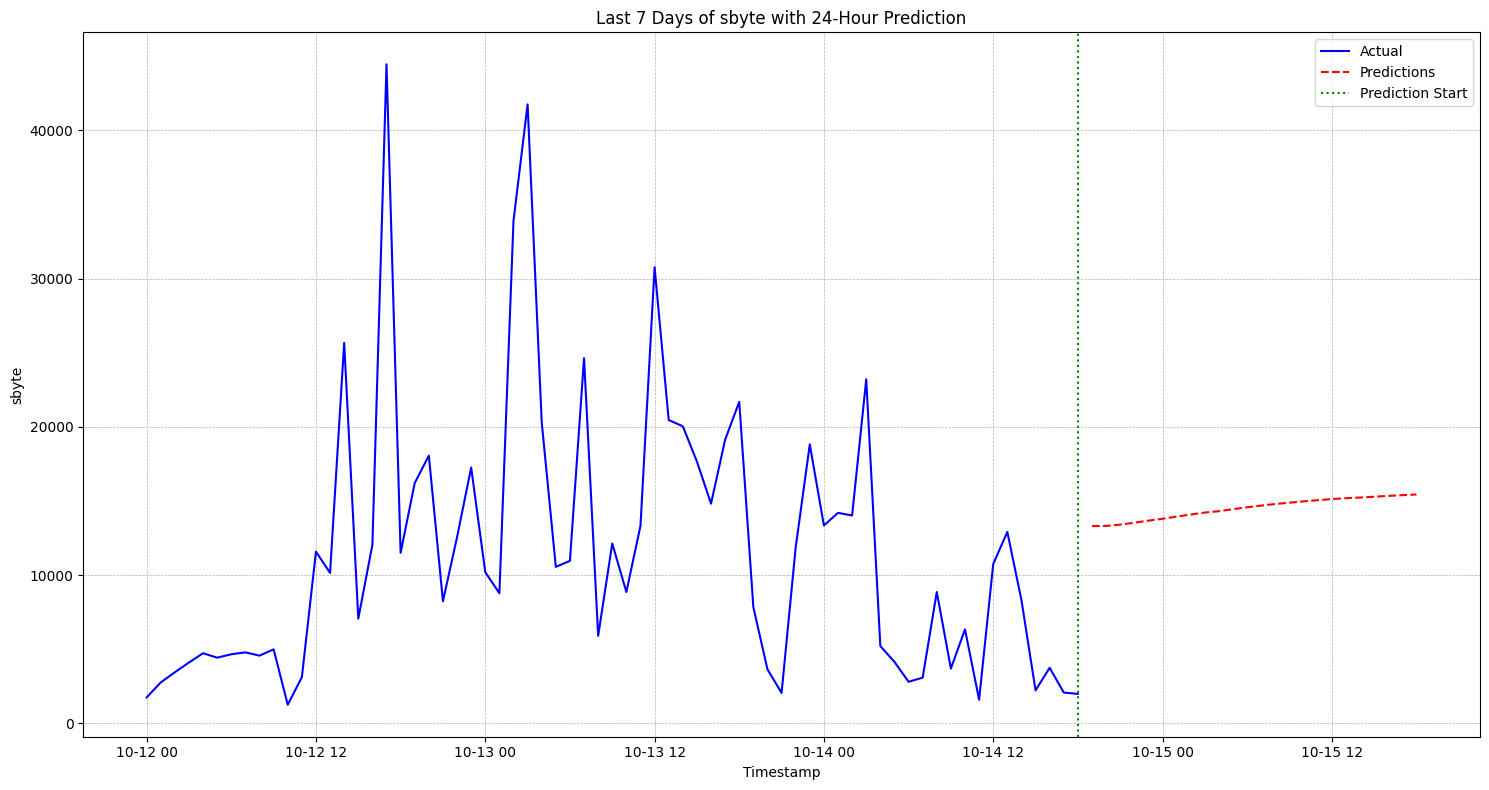

Predicted sbyte for 2024-10-14 19:00:00: 13309.36
Predicted sbyte for 2024-10-14 20:00:00: 13318.82
Predicted sbyte for 2024-10-14 21:00:00: 13407.18
Predicted sbyte for 2024-10-14 22:00:00: 13536.89
Predicted sbyte for 2024-10-14 23:00:00: 13674.12
Predicted sbyte for 2024-10-15 00:00:00: 13802.53
Predicted sbyte for 2024-10-15 01:00:00: 13948.29
Predicted sbyte for 2024-10-15 02:00:00: 14088.19
Predicted sbyte for 2024-10-15 03:00:00: 14221.18
Predicted sbyte for 2024-10-15 04:00:00: 14313.95
Predicted sbyte for 2024-10-15 05:00:00: 14450.05
Predicted sbyte for 2024-10-15 06:00:00: 14576.12
Predicted sbyte for 2024-10-15 07:00:00: 14692.38
Predicted sbyte for 2024-10-15 08:00:00: 14798.45
Predicted sbyte for 2024-10-15 09:00:00: 14887.10
Predicted sbyte for 2024-10-15 10:00:00: 14976.21
Predicted sbyte for 2024-10-15 11:00:00: 15055.32
Predicted sbyte for 2024-10-15 12:00:00: 15131.68
Predicted sbyte for 2024-10-15 13:00:00: 15188.83
Predicted sbyte for 2024-10-15 14:00:00: 15235.71


In [57]:

# Plot
plt.figure(figsize=(15, 8))
plt.plot(last_7_days.index, last_7_days.values, label='Actual', color='blue')
plt.plot(prediction_dates, predictions, label='Predictions', color='red', linestyle='--')
plt.axvline(x=last_7_days.index[-1], color='green', linestyle=':', label='Prediction Start')
plt.xlabel('Timestamp')
plt.ylabel('sbyte')
plt.title('Last 7 Days of sbyte with 24-Hour Prediction')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Print the predictions
for date, prediction in zip(prediction_dates, predictions):
    print(f"Predicted sbyte for {date}: {prediction:.2f}")